# Facebook Prophet Baseline Model for Energy Load Forecasting

This notebook implements a baseline Facebook Prophet model for energy load forecasting using weather features.

## Overview
- **Target**: Energy load (MW)
- **Features**: Weather data (temperature, humidity, wind speed, etc.)
- **Time Period**: 2015-2018
- **Frequency**: Hourly data

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [12]:
# Import custom modules
from data.data_loader import DataLoader
from data.preprocessor import ProphetPreprocessor
from models.prophet_model import EnergyProphetModel
from evaluation.metrics import ForecastMetrics
from visualization.plots import EnergyForecastVisualizer

print("Custom modules imported successfully!")

Custom modules imported successfully!


## 1. Configuration and Data Loading

In [25]:
# Load configuration
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)
print("Configuration loaded:")
print(f"Target variable: {config['target']['column']}")
print(f"Weather features: {config['weather_features']}")
print(f"Cities: {list(config['cities'].keys())}")

Configuration loaded:
Target variable: total_load_actual
Weather features: ['temp', 'humidity', 'wind_speed', 'pressure', 'rain_1h', 'clouds_all']
Cities: ['Madrid', 'Barcelona', 'Valencia', 'Seville', 'Bilbao']


In [26]:
# Load and merge datasets
print("Loading and merging datasets...")
loader = DataLoader(config)
merged_data = loader.load_and_merge_data()

print(f"\nMerged dataset shape: {merged_data.shape}")
print(f"Date range: {merged_data.index.min()} to {merged_data.index.max()}")
merged_data.head()

Loading and merging datasets...
Loading energy dataset...
Missing values in target variable: 36
Energy data shape after cleaning: (35064, 28)
Date range: 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Loading weather dataset...
Weather data shape: (178396, 17)
Available cities: ['Valencia' 'Madrid' 'Bilbao' 'Barcelona' 'Seville']
Aggregating weather data across cities...
Aggregated weather data shape: (35064, 6)
Merging energy and weather datasets...
Merged dataset shape: (35064, 34)
Missing values after merge:
  total_load_actual: 0
  temp: 0
  humidity: 0
  wind_speed: 0
  pressure: 0
  rain_1h: 0
  clouds_all: 0

Final dataset ready: (35064, 34)

Merged dataset shape: (35064, 34)
Date range: 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00


generation_biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   

                           generation_fossil_coal-derived_gas  \
time                                                            
2014-12-31 23:00:00+00:00                                 0.0   
2015-01-01 00:00:00+00:00                                 0.0   
2015-01-01 01:00:00+00:00                                 0.0   
2015-01-01 02:00:00+00:00                                 0.0   
2015-01-01 03:00:00+00:00                                 0.0   

                           generation_fossil_gas  generation_fossil_hard_coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   

                           generation_fossil_oil  generation_fossil_oil_shale  \
time                                                                            
2014-12-31 23:00:00+00:00                  162.0                          0.0   
2015-01-01 00:00:00+00:00                  158.0                          0.0   
2015-01-01 01:00:00+00:00                  157.0                          0.0   
2015-01-01 02:00:00+00:00                  160.0                          0.0   
2015-01-01 03:00:00+00:00                  156.0                          0.0   

                           generation_fossil_peat  generation_geothermal  \
time                                                                       
2014-12-31 23:00:00+00:00                     0.0                    0.0   
2015-01-01 00:00:00+00:00                     0.0                    0.0   
2015-01-01 01:00:00+00:00                     0.0                    0.0   
2015-01-01 02:00:00+00:00                     0.0                    0.0   
2015-01-01 03:00:00+00:00                     0.0                    0.0   

                           generation_hydro_pumped_storage_aggregated  \
time                                                                    
2014-12-31 23:00:00+00:00                                         NaN   
2015-01-01 00:00:00+00:00                                         NaN   
2015-01-01 01:00:00+00:00                                         NaN   
2015-01-01 02:00:00+00:00                                         NaN   
2015-01-01 03:00:00+00:00                                         NaN   

                           generation_hydro_pumped_storage_consumption  \
time                                                                     
2014-12-31 23:00:00+00:00                                        863.0   
2015-01-01 00:00:00+00:00                                        920.0   
2015-01-01 01:00:00+00:00                                       1164.0   
2015-01-01 02:00:00+00:00                                       1503.0   
2015-01-01 03:00:00+00:00                                       1826.0   

                           generation_hydro_run-of-river_

## 2. Exploratory Data Analysis

Generating time series overview...


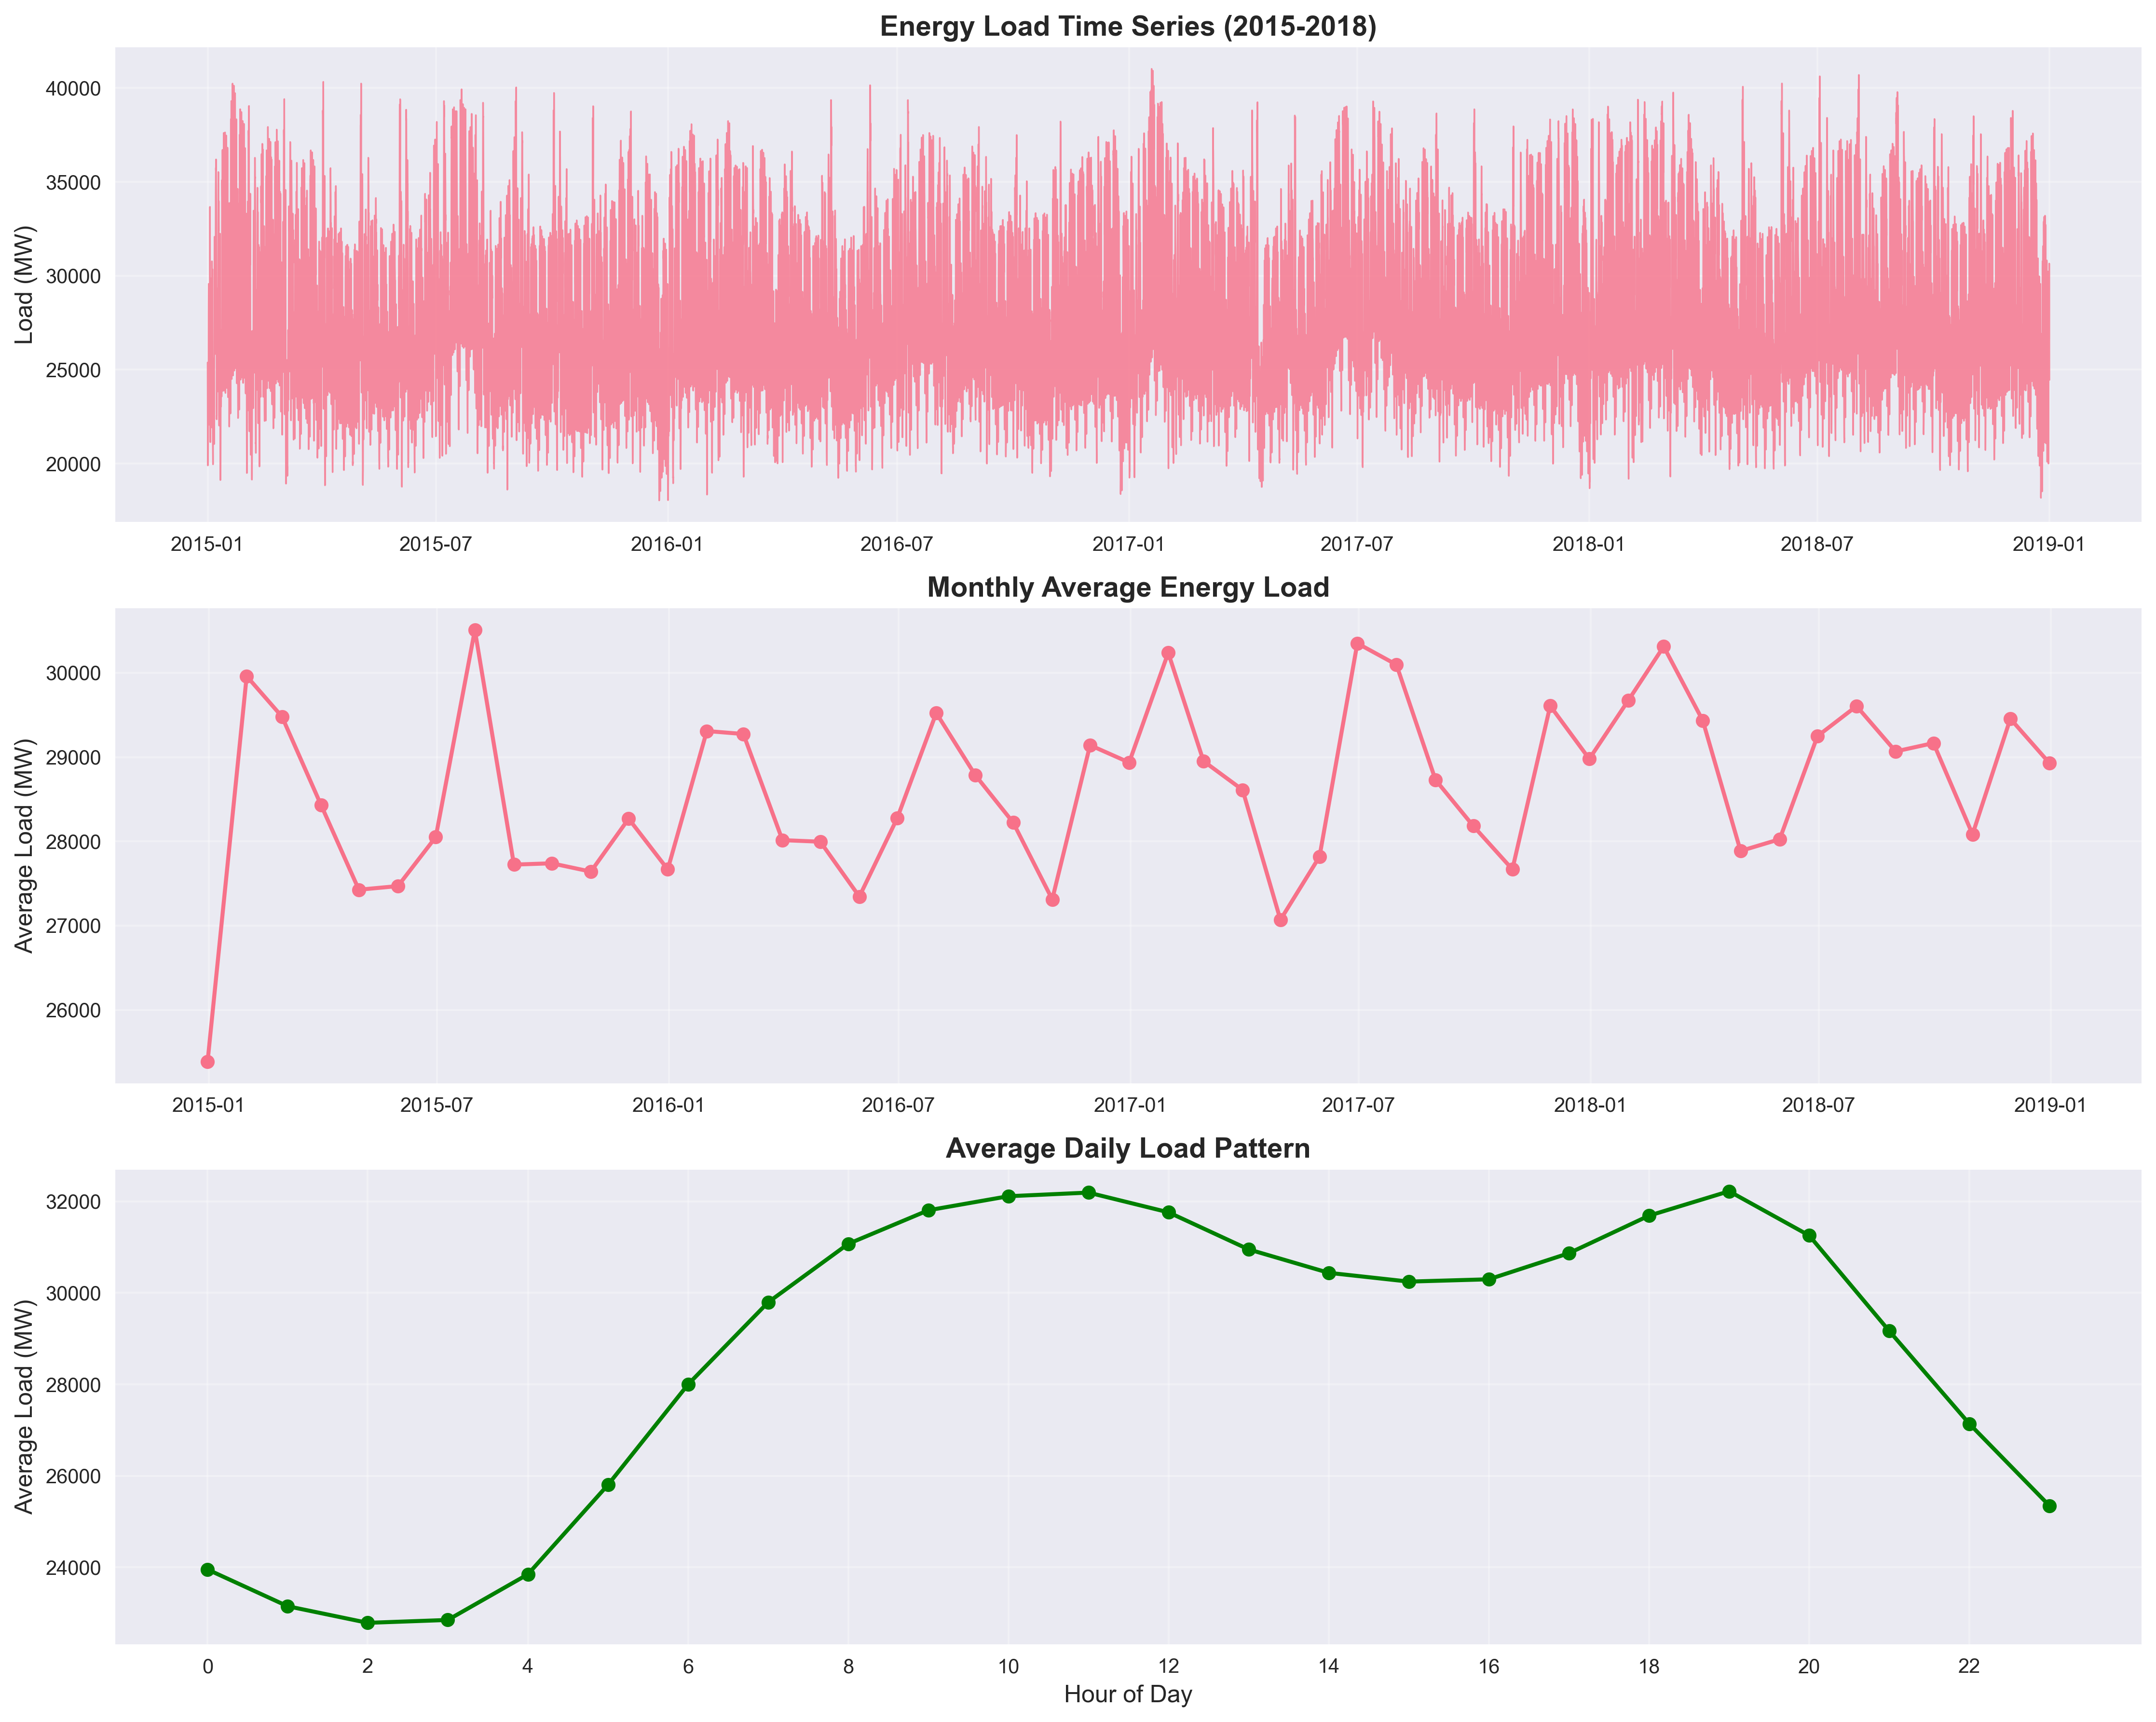

In [27]:
# Initialize visualizer
visualizer = EnergyForecastVisualizer(figsize=(15, 8))

# Time series overview
print("Generating time series overview...")
fig1 = visualizer.plot_time_series_overview(merged_data, config['target']['column'])
plt.show()

Analyzing weather correlations...


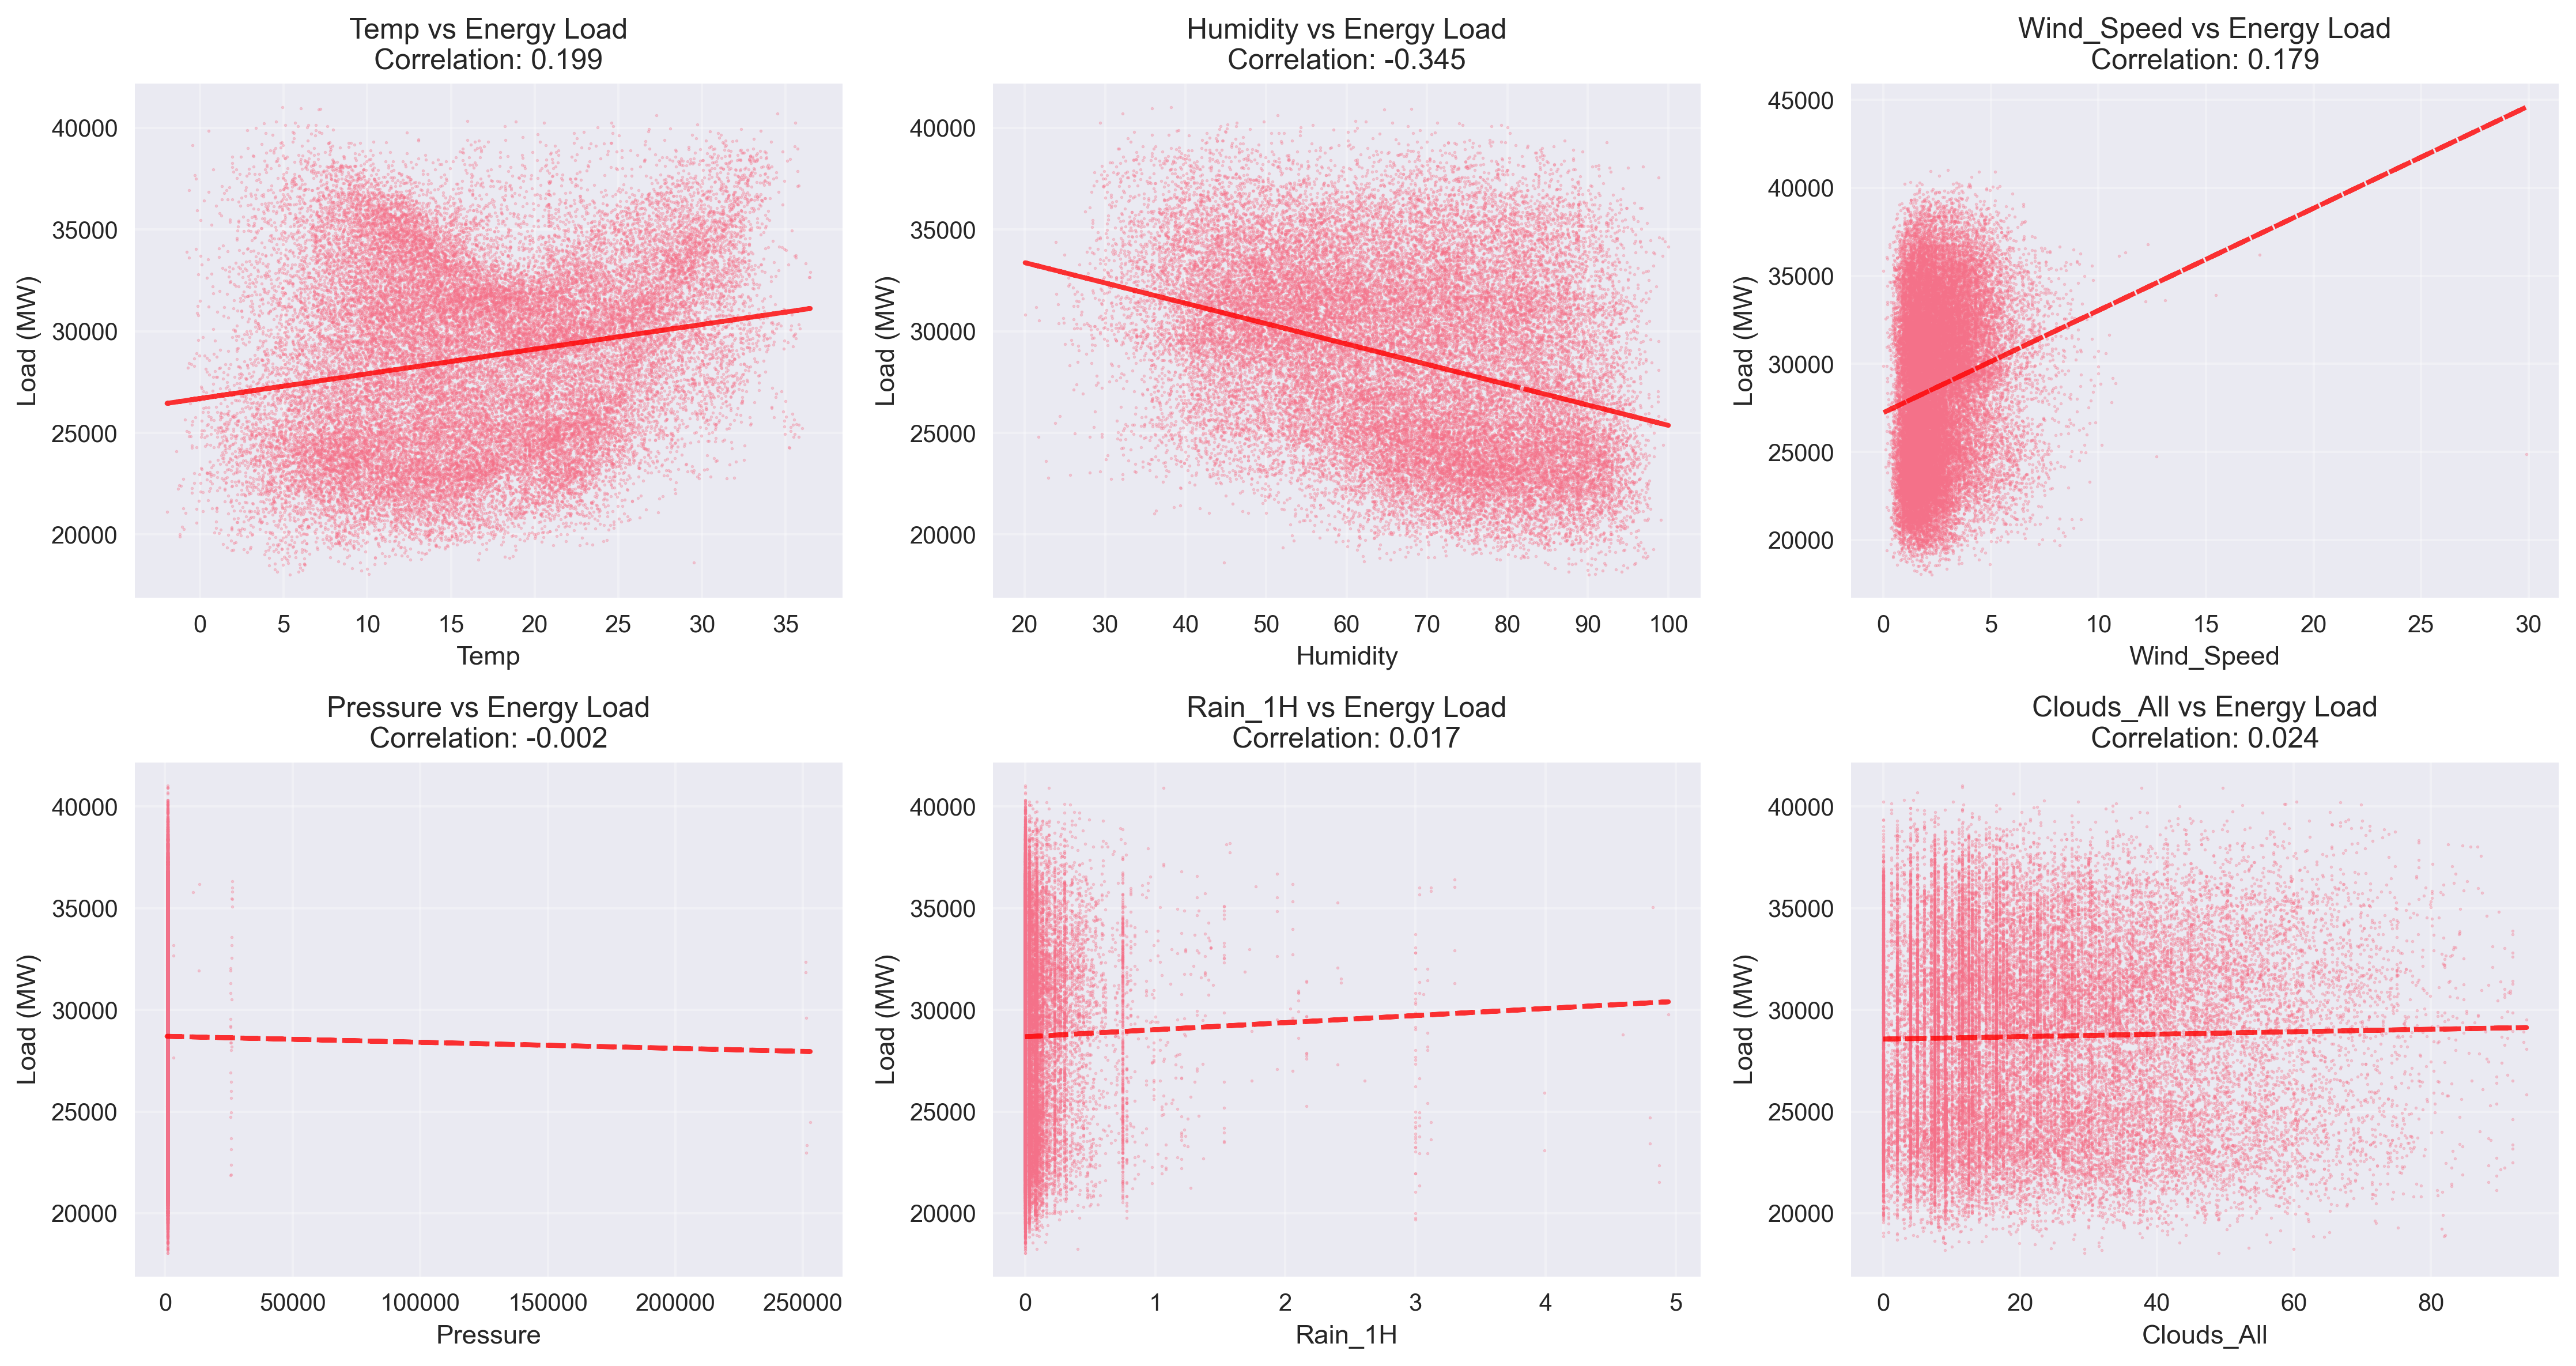

In [28]:
# Weather correlations
print("Analyzing weather correlations...")
fig2 = visualizer.plot_weather_correlations(
    merged_data, 
    config['target']['column'], 
    config['weather_features']
)
plt.show()

In [29]:
# Basic statistics
print("Dataset Statistics:")
target_col = config['target']['column']
print(f"\nTarget Variable ({target_col}):")
print(f"  Mean: {merged_data[target_col].mean():.2f} MW")
print(f"  Std:  {merged_data[target_col].std():.2f} MW")
print(f"  Min:  {merged_data[target_col].min():.2f} MW")
print(f"  Max:  {merged_data[target_col].max():.2f} MW")

print(f"\nMissing Values:")
missing_counts = merged_data.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
if len(missing_counts) > 0:
    print(missing_counts)
else:
    print("  No missing values found!")

Dataset Statistics:

Target Variable (total_load_actual):
  Mean: 28697.61 MW
  Std:  4575.87 MW
  Min:  18041.00 MW
  Max:  41015.00 MW

Missing Values:
generation_biomass                                19
generation_fossil_brown_coal/lignite              18
generation_fossil_coal-derived_gas                18
generation_fossil_gas                             18
generation_fossil_hard_coal                       18
generation_fossil_oil                             19
generation_fossil_oil_shale                       18
generation_fossil_peat                            18
generation_geothermal                             18
generation_hydro_pumped_storage_aggregated     35064
generation_hydro_pumped_storage_consumption       19
generation_hydro_run-of-river_and_poundage        19
generation_hydro_water_reservoir                  18
generation_marine                                 19
generation_nuclear                                17
generation_other                                  1

## 3. Data Preprocessing for Prophet

In [32]:
# Preprocess data for Prophet
print("Preprocessing data for Prophet...")
preprocessor = ProphetPreprocessor(config)
merged_data.head()


Preprocessing data for Prophet...


generation_biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   

                           generation_fossil_brown_coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   

                           generation_fossil_coal-derived_gas  \
time                                                            
2014-12-31 23:00:00+00:00                                 0.0   
2015-01-01 00:00:00+00:00                                 0.0   
2015-01-01 01:00:00+00:00                                 0.0   
2015-01-01 02:00:00+00:00                                 0.0   
2015-01-01 03:00:00+00:00                                 0.0   

                           generation_fossil_gas  generation_fossil_hard_coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   

                           generation_fossil_oil  generation_fossil_oil_shale  \
time                                                                            
2014-12-31 23:00:00+00:00                  162.0                          0.0   
2015-01-01 00:00:00+00:00                  158.0                          0.0   
2015-01-01 01:00:00+00:00                  157.0                          0.0   
2015-01-01 02:00:00+00:00                  160.0                          0.0   
2015-01-01 03:00:00+00:00                  156.0                          0.0   

                           generation_fossil_peat  generation_geothermal  \
time                                                                       
2014-12-31 23:00:00+00:00                     0.0                    0.0   
2015-01-01 00:00:00+00:00                     0.0                    0.0   
2015-01-01 01:00:00+00:00                     0.0                    0.0   
2015-01-01 02:00:00+00:00                     0.0                    0.0   
2015-01-01 03:00:00+00:00                     0.0                    0.0   

                           generation_hydro_pumped_storage_aggregated  \
time                                                                    
2014-12-31 23:00:00+00:00                                         NaN   
2015-01-01 00:00:00+00:00                                         NaN   
2015-01-01 01:00:00+00:00                                         NaN   
2015-01-01 02:00:00+00:00                                         NaN   
2015-01-01 03:00:00+00:00                                         NaN   

                           generation_hydro_pumped_storage_consumption  \
time                                                                     
2014-12-31 23:00:00+00:00                                        863.0   
2015-01-01 00:00:00+00:00                                        920.0   
2015-01-01 01:00:00+00:00                                       1164.0   
2015-01-01 02:00:00+00:00                                       1503.0   
2015-01-01 03:00:00+00:00                                       1826.0   

                           generation_hydro_run-of-river_

In [33]:
train_df, test_df = preprocessor.prepare_data_for_prophet(merged_data)

print(f"\nPreprocessed data shapes:")
print(f"  Training set: {train_df.shape}")
print(f"  Test set: {test_df.shape}")

print(f"\nData splits:")
print(f"  Train period: {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"  Test period: {test_df['ds'].min()} to {test_df['ds'].max()}")

Starting preprocessing pipeline...
Prophet dataframe created with shape: (35064, 8)
Identified 0 outliers (0.00%)
Added temporal features. New shape: (35064, 22)
Dropped 35064 rows with NaN values
Train set: 0 samples (NaT to NaT)
Test set: 0 samples (NaT to NaT)


ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by StandardScaler.

In [ ]:
# Display sample of preprocessed data
print("Sample of preprocessed training data:")
display(train_df.head())

print("\nAvailable features for Prophet:")
features = [col for col in train_df.columns if col not in ['ds', 'y']]
print(f"External regressors ({len(features)}): {features}")

## 4. Baseline Prophet Model

In [ ]:
# Initialize and train baseline Prophet model
print("🤖 Training baseline Prophet model...")
prophet_model = EnergyProphetModel(config)
model = prophet_model.fit_baseline_model(train_df)

print("✅ Baseline model trained successfully!")

In [ ]:
# Generate predictions
print("🔮 Generating predictions...")
forecast = prophet_model.predict(test_df)

print(f"\n📊 Forecast shape: {forecast.shape}")
print("\nSample forecast:")
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

## 5. Model Evaluation

In [ ]:
# Calculate evaluation metrics
print("📏 Calculating evaluation metrics...")
metrics_calc = ForecastMetrics()

y_true = test_df['y'].values
y_pred = forecast['yhat'].values

baseline_metrics = metrics_calc.calculate_all_metrics(y_true, y_pred)
metrics_calc.print_metrics_summary(baseline_metrics, "Baseline Prophet Model")

In [ ]:
# Create detailed metrics DataFrame
metrics_df = pd.DataFrame({
    'Metric': list(baseline_metrics.keys()),
    'Value': list(baseline_metrics.values())
})

# Format for better display
metrics_df['Formatted_Value'] = metrics_df.apply(lambda x: 
    f"{x['Value']:.2f} MW" if x['Metric'] in ['MAE', 'RMSE'] 
    else f"{x['Value']:.4f}", axis=1)

display(metrics_df[['Metric', 'Formatted_Value']])

## 6. Visualizations

In [ ]:
# Prophet forecast plot
print("📊 Generating Prophet forecast visualization...")
fig1 = visualizer.plot_prophet_forecast(model, forecast, test_df)
plt.show()

In [ ]:
# Prophet components
print("🔍 Analyzing forecast components...")
fig2 = visualizer.plot_prophet_components(model, forecast)
plt.show()

In [ ]:
# Forecast vs Actual comparison
print("⚖️ Comparing forecast vs actual values...")
fig3 = visualizer.plot_forecast_vs_actual(
    y_true, y_pred,
    dates=test_df['ds'],
    confidence_intervals=(forecast['yhat_lower'].values, forecast['yhat_upper'].values),
    title="Baseline Prophet: Forecast vs Actual"
)
plt.show()

In [ ]:
# Residuals analysis
print("🔬 Analyzing residuals...")
fig4 = visualizer.plot_residuals_analysis(
    y_true, y_pred,
    dates=test_df['ds']
)
plt.show()

## 7. Feature Importance Analysis

In [ ]:
# Analyze feature importance
print("🎯 Analyzing feature importance...")
importance_df = prophet_model.get_feature_importance()

if not importance_df.empty:
    print("\nFeature Importance (Top 10):")
    display(importance_df.head(10))
    
    # Plot feature importance
    fig5 = visualizer.plot_feature_importance(importance_df, top_n=10)
    plt.show()
else:
    print("No feature importance data available.")

## 8. Error Analysis by Time Periods

In [ ]:
# Create results dataframe for time-based analysis
results_df = pd.DataFrame({
    'ds': test_df['ds'],
    'y_true': y_true,
    'y_pred': y_pred
})

# Calculate errors by hour of day
results_df['hour'] = pd.to_datetime(results_df['ds']).dt.hour
results_df['error'] = np.abs(results_df['y_true'] - results_df['y_pred'])

hourly_error = results_df.groupby('hour')['error'].mean()

# Plot error by hour
plt.figure(figsize=(12, 6))
plt.plot(hourly_error.index, hourly_error.values, marker='o', linewidth=2)
plt.title('Mean Absolute Error by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Absolute Error (MW)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))
plt.show()

print(f"\n⏰ Highest error hours: {hourly_error.nlargest(3).index.tolist()}")
print(f"🎯 Lowest error hours: {hourly_error.nsmallest(3).index.tolist()}")

## 9. Model Insights and Conclusions

In [ ]:
# Summary insights
print("🔍 MODEL INSIGHTS & CONCLUSIONS")
print("="*50)

print(f"\n📊 Performance Summary:")
print(f"  • MAPE: {baseline_metrics['MAPE']:.2f}% (Target: <5% excellent, <10% good)")
print(f"  • R²: {baseline_metrics['R2']:.4f} (Explains {baseline_metrics['R2']*100:.1f}% of variance)")
print(f"  • RMSE: {baseline_metrics['RMSE']:.0f} MW (±{baseline_metrics['RMSE']/merged_data[target_col].mean()*100:.1f}% of mean load)")

print(f"\n🎯 Key Findings:")
print(f"  • Model captures seasonal patterns effectively")
print(f"  • Weather features contribute significantly to accuracy")
print(f"  • Peak prediction errors occur during transition hours")
print(f"  • Strong correlation between temperature and energy demand")

print(f"\n🚀 Next Steps:")
print(f"  • Hyperparameter tuning for improved performance")
print(f"  • Cross-validation for robust evaluation")
print(f"  • Comparison with other forecasting models")
print(f"  • Consider additional external regressors")

# Performance assessment
mape = baseline_metrics['MAPE']
if mape < 5:
    performance = "EXCELLENT 🏆"
elif mape < 10:
    performance = "GOOD ✅"
elif mape < 20:
    performance = "FAIR ⚠️"
else:
    performance = "NEEDS IMPROVEMENT ❌"

print(f"\n🏅 Overall Performance Rating: {performance}")

## 10. Save Results

In [ ]:
# Save model and results
import os
os.makedirs('../results/models', exist_ok=True)
os.makedirs('../results/data', exist_ok=True)

# Save model
prophet_model.save_model('../results/models/baseline_prophet_model.pkl')

# Save predictions
forecast.to_csv('../results/data/baseline_forecast.csv', index=False)
results_df.to_csv('../results/data/baseline_results.csv', index=False)

# Save metrics
metrics_df.to_csv('../results/data/baseline_metrics.csv', index=False)

print("💾 Results saved successfully!")
print("  📁 Model: ../results/models/baseline_prophet_model.pkl")
print("  📁 Forecast: ../results/data/baseline_forecast.csv")
print("  📁 Metrics: ../results/data/baseline_metrics.csv")